Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

# Mounting Google Drive


In [1]:
# Mount Drive which has dataset
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [3]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [4]:
# Training and Test dataset path
train_data_path='/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train'
test_data_path='/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Test'
data_dir_train = pathlib.Path(train_data_path)
data_dir_test = pathlib.Path(test_data_path)

In [5]:
# Get the number of images in the training dataset
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
# Get the number of images in the testing dataset
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [7]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 118 files belonging to 9 classes.
Using 23 files for validation.


In [9]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

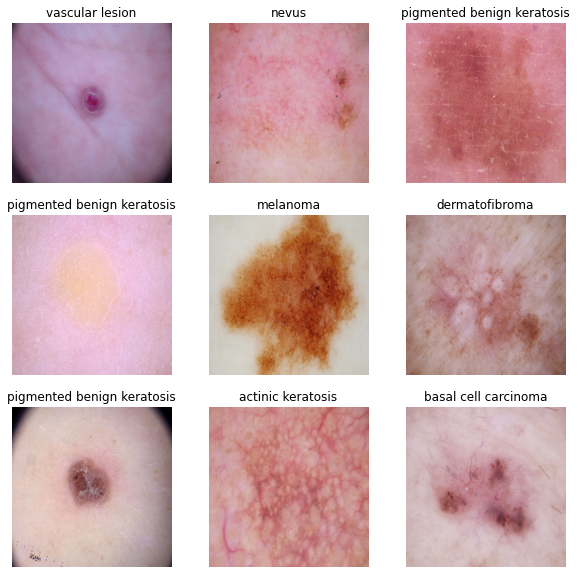

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [12]:
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
# Rescaling the images so that the pixel values are between (0,1)
model = Sequential(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180,180,3)))
model.add(Conv2D(32, (3, 3), padding='same', input_shape=(180,180,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(9))
model.add(Activation('softmax'))

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [13]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [14]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 activation (Activation)     (None, 180, 180, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 activation_1 (Activation)   (None, 90, 90, 64)        0         
                                                        

### Train the model

In [15]:
#With 20 epochs training the model
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 478s 215ms/step - loss: 3.2775 - accuracy: 0.2673 - val_loss: 2.2474 - val_accuracy: 0.2609
Epoch 2/20
56/56 [==============================] - 2s 43ms/step - loss: 1.6930 - accuracy: 0.3912 - val_loss: 2.4027 - val_accuracy: 0.3043
Epoch 3/20
56/56 [==============================] - 2s 43ms/step - loss: 1.5301 - accuracy: 0.4660 - val_loss: 2.5733 - val_accuracy: 0.2609
Epoch 4/20
56/56 [==============================] - 2s 43ms/step - loss: 1.3424 - accuracy: 0.5340 - val_loss: 2.8888 - val_accuracy: 0.2609
Epoch 5/20
56/56 [==============================] - 2s 43ms/step - loss: 1.1836 - accuracy: 0.5787 - val_loss: 3.0957 - val_accuracy: 0.1739
Epoch 6/20
56/56 [==============================] - 2s 43ms/step - loss: 1.0134 - accuracy: 0.6473 - val_loss: 3.3217 - val_accuracy: 0.2174
Epoch 7/20
56/56 [==============================] - 2s 43ms/step - loss: 0.8435 - accuracy: 0.7054 - val_loss: 3.8374 - val_accuracy: 0.2174
Epoch 8/20

### Visualizing training results

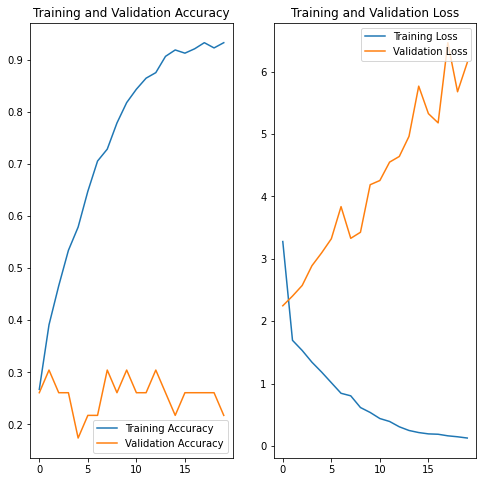

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Findings:

It can be seen from the above graphs that the Training accuracy is increasing with the number of epochs, but, the validation accuracy is randomly increasing and decreasing. Also, the difference between training accuracy and validation accuracy is very huge.

The training loss is decreasing with a big gap for first 2 epochs and after that there is a gradual decrease as epochs increase. The validation loss increase and decrease randomly

So, we can say that our model is Overfitting.

#### As the model is overfitting, we would go with some Augumentation Strategy. It is important to note that this dataset is related to detection of skin cancer, we cannot apply any brightness or contrast related augmentation. We will apply only Horizontal and vertical rotation


In [17]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180,180,3))
])
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

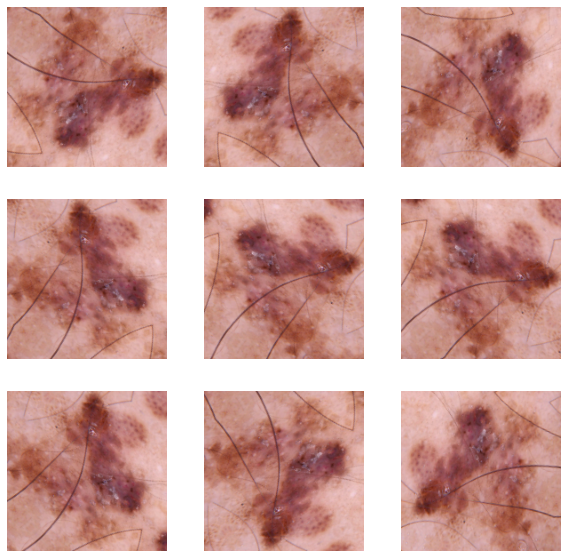

In [18]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

#### With the above Augmentation Startegy, lets go ahead and create new model. In this model, we will also add Dropout layers since we saw our previous model was overfitting too much

In [19]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

# Created Seqential model with rescaling and augmentation startegy
model_aug = tf.keras.Sequential([
  resize_and_rescale,
  data_augmentation
])
model_aug.add(Conv2D(32, (3, 3), padding='same', input_shape=(180,180,3)))
model_aug.add(Activation('relu'))
model_aug.add(MaxPooling2D(pool_size=(2, 2)))
model_aug.add(Dropout(0.25))
model_aug.add(Conv2D(64, (3, 3), padding='same'))
model_aug.add(Activation('relu'))
model_aug.add(MaxPooling2D(pool_size=(2, 2)))
model_aug.add(Dropout(0.25))
model_aug.add(Flatten())
model_aug.add(Dense(512))
model_aug.add(Activation('relu'))
model_aug.add(Dropout(0.5))
model_aug.add(Dense(9))
model_aug.add(Activation('softmax'))

### Compiling the model

In [20]:
## Your code goes here
model_aug.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [21]:
model_aug.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 sequential_2 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 activation_4 (Activation)   (None, 180, 180, 32)      0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 90, 90, 32)        0         
                                                      

### Training the model

In [22]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model_aug.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 5s 72ms/step - loss: 4.9365 - accuracy: 0.1708 - val_loss: 2.1974 - val_accuracy: 0.1739
Epoch 2/20
56/56 [==============================] - 4s 69ms/step - loss: 2.0121 - accuracy: 0.2165 - val_loss: 2.2078 - val_accuracy: 0.1739
Epoch 3/20
56/56 [==============================] - 4s 69ms/step - loss: 1.8627 - accuracy: 0.3237 - val_loss: 2.0854 - val_accuracy: 0.2609
Epoch 4/20
56/56 [==============================] - 4s 69ms/step - loss: 1.7011 - accuracy: 0.3795 - val_loss: 2.0442 - val_accuracy: 0.1739
Epoch 5/20
56/56 [==============================] - 4s 69ms/step - loss: 1.6721 - accuracy: 0.4046 - val_loss: 1.9819 - val_accuracy: 0.2609
Epoch 6/20
56/56 [==============================] - 4s 68ms/step - loss: 1.6579 - accuracy: 0.4035 - val_loss: 1.9177 - val_accuracy: 0.2174
Epoch 7/20
56/56 [==============================] - 4s 69ms/step - loss: 1.5627 - accuracy: 0.4565 - val_loss: 2.0057 - val_accuracy: 0.3043
Epoch 8/20
56

### Visualizing the results

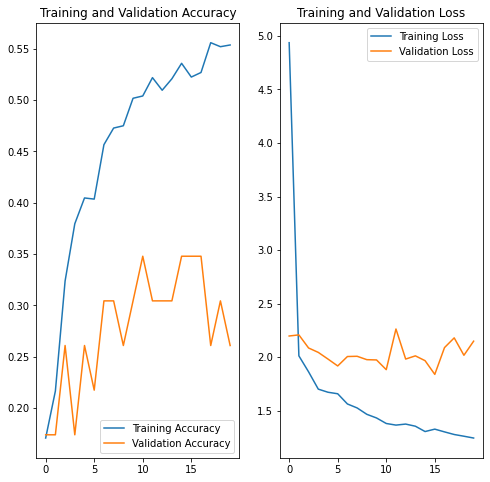

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Findings:

It can be seen from the above graphs that the Training accuracy is increasing with the number of epochs, but, the validation accuracy is randomly increasing and decreasing. However, the difference between training accuracy and validation accuracy is better as compared to the previous model

The training loss has decreased a lot for first 2 epochs and after that there is gradual decreas as epochs increase. Also, the validation loss increase and decrease randomly

From this, we see that our model is still Overfitting, but with the help of Data Augmentation startegy it is better than our first model, so we will go ahead with data-augmentation strategies.


#### Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [24]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
len(path_list)

2239

In [25]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/drive/MyDrive/Skin cancer ISIC The In...,actinic keratosis
1,/content/drive/MyDrive/Skin cancer ISIC The In...,actinic keratosis
2,/content/drive/MyDrive/Skin cancer ISIC The In...,actinic keratosis
3,/content/drive/MyDrive/Skin cancer ISIC The In...,actinic keratosis
4,/content/drive/MyDrive/Skin cancer ISIC The In...,actinic keratosis
...,...,...
2234,/content/drive/MyDrive/Skin cancer ISIC The In...,dermatofibroma
2235,/content/drive/MyDrive/Skin cancer ISIC The In...,dermatofibroma
2236,/content/drive/MyDrive/Skin cancer ISIC The In...,dermatofibroma
2237,/content/drive/MyDrive/Skin cancer ISIC The In...,dermatofibroma


Class=0, n=114 (5.092%)
Class=5, n=462 (20.634%)
Class=7, n=181 (8.084%)
Class=3, n=438 (19.562%)
Class=6, n=77 (3.439%)
Class=4, n=357 (15.945%)
Class=8, n=139 (6.208%)
Class=1, n=376 (16.793%)
Class=2, n=95 (4.243%)


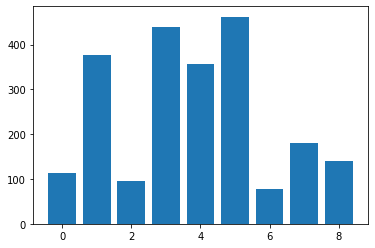

In [26]:
from sklearn.preprocessing import LabelEncoder
from collections import Counter
# split into input and output elements
X, y = original_df['Path'], original_df['Label']
# label encode the target variable
y = LabelEncoder().fit_transform(y)
# summarize distribution
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

#### Findings: 

Which class has the least number of samples?

- Seborrheic Keratosis has least number of samples in the training dataset (having only 77 images)

Which classes dominate the data in terms proportionate number of samples?

- Pigmented Benign Keratosis having 462 images with 20.63 %

##### With these findings, we can clearly see that there is class imbalance problem


#### Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [27]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [28]:
path_to_training_dataset="/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F22280CB910>: 100%|██████████| 500/500 [00:19<00:00, 25.51 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F222812FAD0>: 100%|██████████| 500/500 [00:21<00:00, 23.74 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F2228073A10>: 100%|██████████| 500/500 [00:18<00:00, 27.19 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F21E59AE390>: 100%|██████████| 500/500 [01:35<00:00,  5.26 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=2048x1536 at 0x7F222AA71B90>: 100%|██████████| 500/500 [01:20<00:00,  6.21 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F21E5964A50>: 100%|██████████| 500/500 [00:21<00:00, 23.36 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F22280C3310>: 100%|██████████| 500/500 [00:39<00:00, 12.78 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F2228036750>: 100%|██████████| 500/500 [00:18<00:00, 27.16 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F21E592F150>: 100%|██████████| 500/500 [00:19<00:00, 25.90 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [29]:
#count the total number of images which are created by above Augmentation step
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [30]:
from glob import glob
import os
import shutil

In [31]:
# Move the newly created images from each class to already existing training class folder
from glob import glob
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0025780.jpg_f96294f8-162f-4018-ad68-593e41998d0a.jpg',
 '/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026625.jpg_c8daf2fe-08d7-4fb1-9500-84fc5056f247.jpg',
 '/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0032404.jpg_d225f9ae-a235-4d32-9081-54273f6e729d.jpg',
 '/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0025953.jpg_8b3e5147-063e-493b-8d12-5afc2de38ffd.jpg',
 '/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0033456.jpg_5b3b19e1-f1f1-4edd

In [32]:
from glob import glob
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [33]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [34]:
new_df

,Path,Label
0,/content/drive/MyDrive/Skin cancer ISIC The In...,actinic keratosis
1,/content/drive/MyDrive/Skin cancer ISIC The In...,actinic keratosis
2,/content/drive/MyDrive/Skin cancer ISIC The In...,actinic keratosis
3,/content/drive/MyDrive/Skin cancer ISIC The In...,actinic keratosis
4,/content/drive/MyDrive/Skin cancer ISIC The In...,actinic keratosis
...,...,...
4495,/content/drive/MyDrive/Skin cancer ISIC The In...,dermatofibroma
4496,/content/drive/MyDrive/Skin cancer ISIC The In...,dermatofibroma
4497,/content/drive/MyDrive/Skin cancer ISIC The In...,dermatofibroma
4498,/content/drive/MyDrive/Skin cancer ISIC The In...,dermatofibroma


In [35]:
#finding new distribution
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [36]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [38]:
#create train_ds
data_dir_train = '/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train'
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [39]:
# create val_ds
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation', ## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [40]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
model_data_aug = tf.keras.Sequential([
  resize_and_rescale
])
model_data_aug.add(Conv2D(32, (2, 2), padding='same', input_shape=(180,180,3)))
model_data_aug.add(Activation('relu'))
model_data_aug.add(MaxPooling2D(pool_size=(2, 2)))
model_data_aug.add(Dropout(0.25))
model_data_aug.add(Conv2D(64, (2, 2), padding='same'))
model_data_aug.add(Activation('relu'))
model_data_aug.add(MaxPooling2D(pool_size=(2, 2)))
model_data_aug.add(Dropout(0.25))
model_data_aug.add(Conv2D(128, (2, 2)))
model_data_aug.add(Activation('relu'))
model_data_aug.add(MaxPooling2D(pool_size=(2, 2)))
model_data_aug.add(Dropout(0.25))
model_data_aug.add(Flatten())
model_data_aug.add(Dense(512))
model_data_aug.add(Activation('relu'))
model_data_aug.add(Dropout(0.5))
model_data_aug.add(Dense(256))
model_data_aug.add(Activation('relu'))
model_data_aug.add(Dropout(0.5))
model_data_aug.add(Dense(9))
model_data_aug.add(Activation('softmax'))

In [41]:
## your code goes here
model_data_aug.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [42]:
## Your code goes here, use 50 epochs.
epochs = 50
history = model_data_aug.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
169/169 [==============================] - 35s 196ms/step - loss: 2.3737 - accuracy: 0.1639 - val_loss: 1.9803 - val_accuracy: 0.1975
Epoch 2/50
169/169 [==============================] - 32s 181ms/step - loss: 1.9058 - accuracy: 0.2669 - val_loss: 1.7652 - val_accuracy: 0.3051
Epoch 3/50
169/169 [==============================] - 32s 183ms/step - loss: 1.7524 - accuracy: 0.3049 - val_loss: 1.6474 - val_accuracy: 0.3771
Epoch 4/50
169/169 [==============================] - 33s 189ms/step - loss: 1.6006 - accuracy: 0.3791 - val_loss: 1.4609 - val_accuracy: 0.4276
Epoch 5/50
169/169 [==============================] - 31s 180ms/step - loss: 1.4703 - accuracy: 0.4225 - val_loss: 1.4804 - val_accuracy: 0.4425
Epoch 6/50
169/169 [==============================] - 32s 181ms/step - loss: 1.3611 - accuracy: 0.4714 - val_loss: 1.2925 - val_accuracy: 0.4989
Epoch 7/50
169/169 [==============================] - 31s 180ms/step - loss: 1.2608 - accuracy: 0.5252 - val_loss: 1.1356 - val_ac

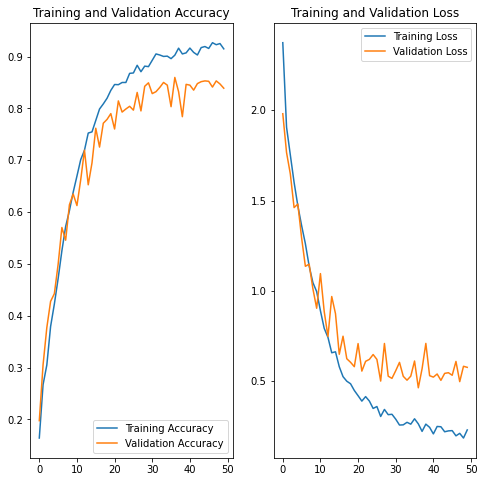

In [43]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Finally, we have built a decent model which is free of overfitting and has good enough accuracy on training as well as validation sets.